### <u><b>Task 1 - Analysis of Nuclear Plants dataset</b></u>

In [ ]:
import findspark

findspark.init()

1. As a first step, you need to load the data from the file `nuclear_plants_small_dataset.csv’ into
a Pyspark DataFrame. Before making any analysis, it is required to know if there are missing
values in the data.

In [ ]:
import pyspark
from pyspark.sql import SparkSession

# instantiating a spark session
spark = SparkSession.builder.getOrCreate()

# creating a dataframe (note: make sure all the files are in the same directory as the script)
df = spark.read.csv('nuclear_plants_small_dataset.csv', inferSchema=True, header=True)
df.show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [ ]:
from pyspark.sql.functions import col, when, count

# checking the number of missing values in each column and show result
df.select([(count(when(col(df_col).isNull(), df_col))/df.count()).alias(df_col) for df_col in df.columns]).show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|   0.0|                 0.0|                 0.0|                  0.0|                 0.0|               0.0|               0.0|               0.0|               0.0|               0.0|               0.0|               0.0|               0.0|
+------+--------

2. It is beneficial to understand the data by looking at the summary statistics. There are two
groups of subjects (i.e., the normal group and the abnormal group) in this dataset. For each
group, show the following summary statistics for each feature in a table: minimum, maximum,
mean, and median values. For each group, plot the box plot for each feature.

In [ ]:
# mean, median, maximum, minimum for each feature of the normal status group
normal_df = df.where(df.Status == 'Normal').summary('mean', '50%', 'max', 'min').drop('Status')
normal_df.show()

+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|   mean|   5.602452811244976|   6.844503413654616|    9.292054016064245|   8.701398192771098|13.797525502008051|3.4156463855421695| 5.923352610441759| 5.586180120481923| 8.441436947791166| 9.699615863453822|19.437804417670666|10.925097590361439|
|    50%|   

In [ ]:
# mean, median, maximum, minimum for each feature of the abnormal status group

abnormal_df = df.where(df.Status == 'Abnormal').summary('mean', '50%', 'max', 'min').drop('Status')
abnormal_df.show()

+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|   mean|   4.396694975903612|   5.914042891566265|    9.164170212851408|    6.00914597991968|14.600728132530124|2.7402695381526083|5.5751150803212814|  4.40782413253012| 7.887688803212859|10.303569907630527| 10.93815894779115|   8.9420846746988|
|    50%|   

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# setting seaborn style
sns.set()
# plotting within the notebook
%matplotlib inline

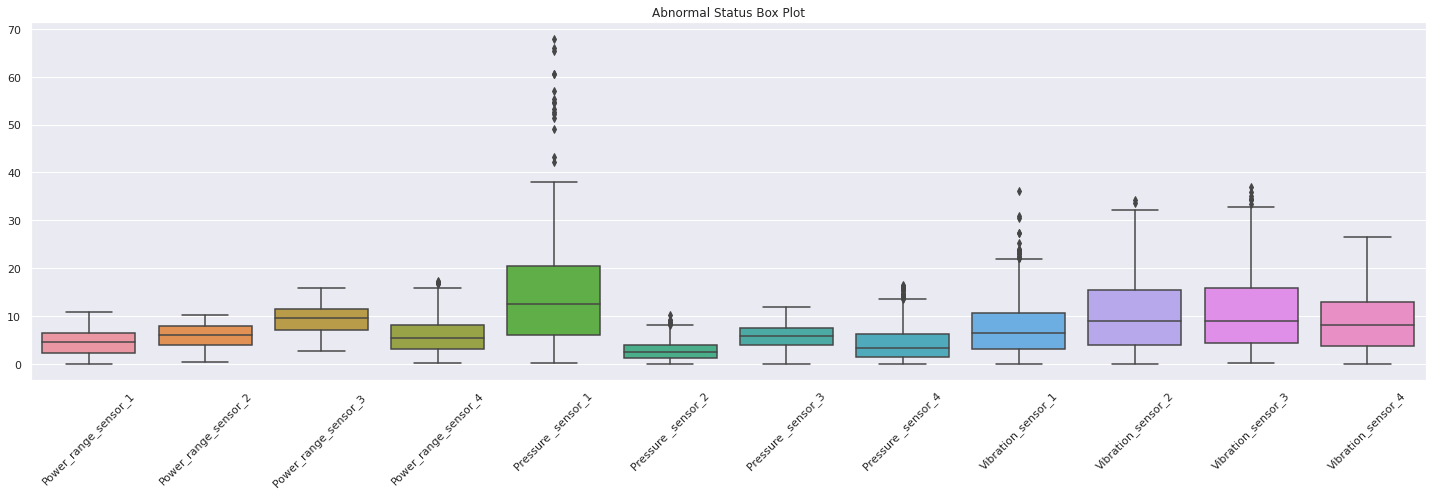

In [ ]:
# getting abnormal status
abnormal_features = df.where(df.Status == 'Abnormal')
# converting from a spark dataframe to pandasfor plotting purposes
pd_abnormal = abnormal_features.toPandas()

# setting figure size
plt.figure(figsize = (20, 7))
# setting title
plt.title('Abnormal Status Features Box Plot')
# rotating x labels for clarity
plt.xticks(rotation=45)
# plotting
sns.boxplot(data=pd_abnormal)
# function to make the plot as neat as possible
plt.tight_layout()

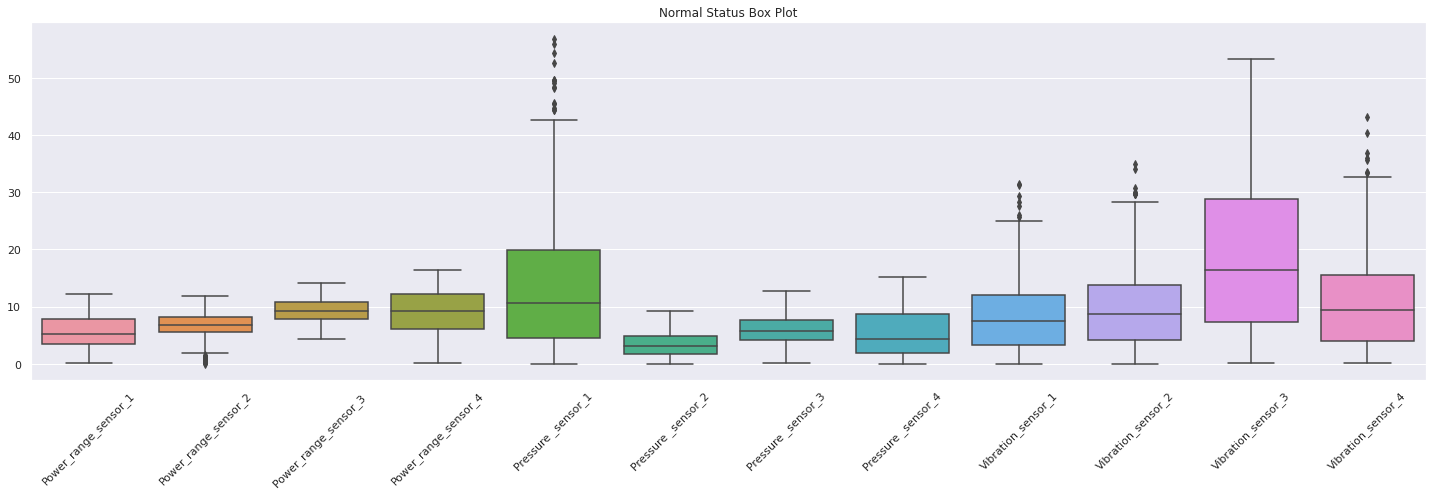

In [ ]:
# getting abnormal status
normal_features = df.where(df.Status == 'Normal')
# converting from a spark dataframe to pandasfor plotting purposes
pd_normal = normal_features.toPandas()

# setting figure size
plt.figure(figsize = (20, 7))
# setting title
plt.title('Normal Status Features Box Plot')
# rotating x labels for clarity
plt.xticks(rotation=45)
# plotting
sns.boxplot(data=pd_normal)
# function to make the plot as neat as possible
plt.tight_layout()

3. To understand the relationship between features. If two features have high correlations, using
only one of them could be enough for our analysis. Show in a table the correlation matrix of
the features, where each element in the matrix shows the correlation coefficient of two
features.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when
from pyspark.ml.stat import Correlation

# changing categorical values in status to numerical ones normal: 1, abnormal: 0
df2 = df.withColumn("Status", when(df.Status == "Normal", 1) \
      .when(df.Status == "Abnormal", 0))
vector_col = 'corr-feature'
assembler = VectorAssembler(inputCols=df2.columns, outputCol=vector_col)
df_vector = assembler.transform(df2).select(vector_col)

# dense matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
columns = df2.columns
df_corr = spark.createDataFrame(corr_matrix, columns)
# spark corralation matrix
df_corr.show()

+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|              Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|  Pressure _sensor_1|  Pressure _sensor_2|  Pressure _sensor_3|  Pressure _sensor_4|  Vibration_sensor_1|  Vibration_sensor_2|  Vibration_sensor_3|  Vibration_sensor_4|
+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0| 0.21816033124911435|   0.201275735419738| 0.025264477546580295|  0.3092700307225316|-0.03440081447574051| 0.15891045149552532| 0.06896155364629367| 0

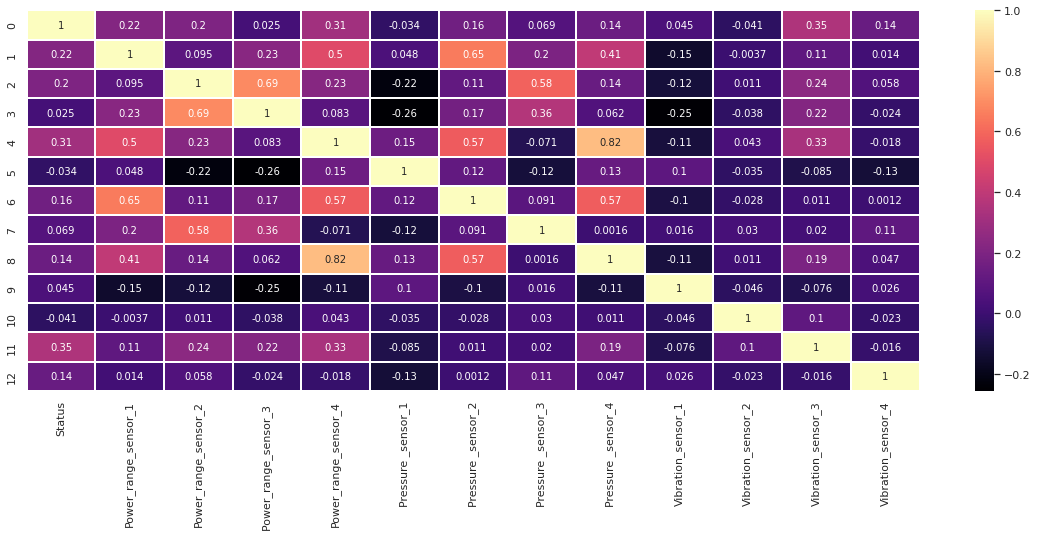

In [ ]:
# using seaborn heatmap to plot the crrelation matrix
# plotting
pdf_corr = df_corr.toPandas()
plt.figure(figsize = (20, 7))
sns.heatmap(data=pdf_corr,
            annot=True,
            cmap='magma',
            linecolor='white',
            linewidths=1)

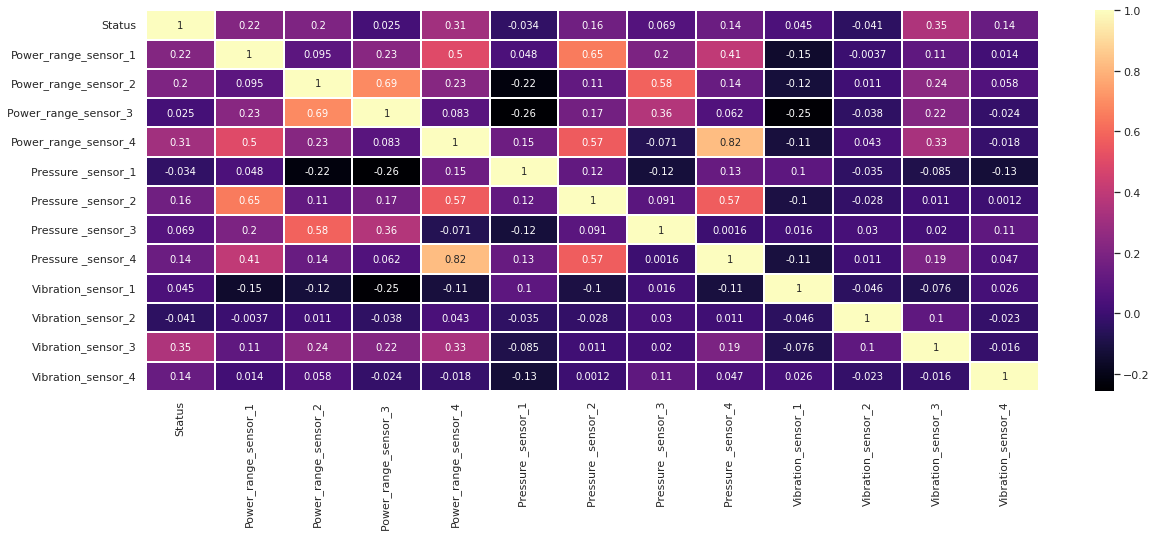

In [ ]:
# we can do the same using pandas correlation function,
# it is quicker, and returns the same results
testing = df2.toPandas()
corr_test = testing.corr()
plt.figure(figsize = (20, 7))
sns.heatmap(data=corr_test,
            annot=True,
            cmap='magma',
            linecolor='white',
            linewidths=1)

4. Shuffle the data samples and split it into a 70% training set and a 30% test set. How many
examples in each group for the training dataset? How many examples in each group for the
testing dataset?


In [ ]:
from pyspark.ml.feature import VectorAssembler

# prior to shuffling and splitting our data it's preferable to format our dataframe appropriately
# we want to use the dataframe df2 as the categorical values have been converted to numerical
# and they will serve as labels (status column)
assembler = VectorAssembler(inputCols=['Power_range_sensor_1',
                                        'Power_range_sensor_2',
                                        'Power_range_sensor_3 ',
                                        'Power_range_sensor_4',
                                        'Pressure _sensor_1',
                                        'Pressure _sensor_2',
                                        'Pressure _sensor_3',
                                        'Pressure _sensor_4',
                                        'Vibration_sensor_1',
                                        'Vibration_sensor_2',
                                        'Vibration_sensor_3',
                                        'Vibration_sensor_4'],
                                        outputCol='features')

out = assembler.transform(df2)
model_df = out.select('features', 'Status').withColumnRenamed("Status", "label")
# showing some sample of our dataframe
model_df.sample(0.01).show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3.3783,5.5801,6....|    1|
|[8.3002,9.6112,13...|    0|
|[7.1384,5.7339,11...|    0|
|[1.225,9.2395,12....|    0|
|[0.8002,7.4799,13...|    0|
+--------------------+-----+



In [ ]:
# shuffling and splitting data into a training and testing set use df2 the reason is mention beneath
# will be using seed 26 when splitting and with the algorithms as well in order to compare the results
train_set, test_set = model_df.randomSplit([0.7, 0.3], seed=26)

Abnormal_train = train_set.where(train_set.label == 0).count()
Normal_train = train_set.where(train_set.label == 1).count()

Abnormal_test = test_set.where(test_set.label == 0).count()
Normal_test = test_set.where(test_set.label == 1).count()

print(f'Total examples for the training set: {train_set.count()}')
print(f'> number of examples in the Normal group: {Normal_train}\n\
> number of examples in the Abnormal group: {Abnormal_train}\n')
print(f'Total of examples for the training set: {test_set.count()}')
print(f'> number of examples in the Normal group: {Normal_test}\n\
> number of examples in the Abnormal group: {Abnormal_test}')

Total examples for the training set: 701
> number of examples in the Normal group: 352
> number of examples in the Abnormal group: 349

Total of examples for the training set: 295
> number of examples in the Normal group: 146
> number of examples in the Abnormal group: 149


5. Train a decision tree, a support vector machine model and an artificial neural network using
the training set, and then apply the trained classifiers to the test set. You will obtain the
predicted labels for the test set. Now evaluate and compare the classifiers, respectively, by
computing the error rate (`Incorrectly Classified Samples divided by `Classified Sample’).
Calculate the sensitivity and specificity.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# decision tree classifier
# instantiating a classifier and setting its parameters, then training it with fit
dt_classifier = DecisionTreeClassifier(labelCol='label', seed=26).fit(train_set)
# predicting with transform
dt_pred = dt_classifier.transform(test_set)
# checking results
dt_pred.select('features', 'label', 'prediction').show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.03825,3.606516...|    0|       0.0|
|[0.1273,8.4933,11...|    0|       0.0|
|[0.190536,4.59448...|    0|       0.0|
|[0.4211,10.1038,1...|    0|       0.0|
|[0.440742,3.52246...|    0|       0.0|
|[0.50898,1.671576...|    0|       0.0|
|[0.563,9.3887,9.8...|    0|       0.0|
|[0.563142,5.89162...|    0|       0.0|
|[0.616284,5.93456...|    0|       0.0|
|[0.6244,9.6515,12...|    0|       1.0|
|[0.649944,3.33285...|    0|       0.0|
|[0.675138,2.23563...|    0|       0.0|
|[0.689214,2.39995...|    0|       0.0|
|[0.8478,10.502,10...|    1|       0.0|
|[0.892704,1.80509...|    0|       0.0|
|[0.9549,5.4639,6....|    1|       1.0|
|[0.982362,3.73156...|    0|       0.0|
|[0.998274,1.51939...|    0|       0.0|
|[1.00011,2.206668...|    0|       0.0|
|[1.101906,3.91741...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
# support vector machine classifier
# instantiating a classifier and setting its parameters, then training it with fit
svc_classifier = LinearSVC(maxIter=10, regParam=0.1, labelCol='label').fit(train_set)
# predicting with transform
svc_pred = svc_classifier.transform(test_set)
# checking results
svc_pred.select('features', 'label', 'prediction').show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.03825,3.606516...|    0|       0.0|
|[0.1273,8.4933,11...|    0|       0.0|
|[0.190536,4.59448...|    0|       0.0|
|[0.4211,10.1038,1...|    0|       0.0|
|[0.440742,3.52246...|    0|       0.0|
|[0.50898,1.671576...|    0|       0.0|
|[0.563,9.3887,9.8...|    0|       0.0|
|[0.563142,5.89162...|    0|       0.0|
|[0.616284,5.93456...|    0|       0.0|
|[0.6244,9.6515,12...|    0|       0.0|
|[0.649944,3.33285...|    0|       0.0|
|[0.675138,2.23563...|    0|       0.0|
|[0.689214,2.39995...|    0|       0.0|
|[0.8478,10.502,10...|    1|       1.0|
|[0.892704,1.80509...|    0|       0.0|
|[0.9549,5.4639,6....|    1|       0.0|
|[0.982362,3.73156...|    0|       0.0|
|[0.998274,1.51939...|    0|       0.0|
|[1.00011,2.206668...|    0|       0.0|
|[1.101906,3.91741...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
# artificial neural network classifier
# setting the artificial neural network layers
layers = [len(assembler.getInputCols()), 4, 2, 2]
# instantiating a classifier and setting its parameters, then training it with fit
ann_classifier = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, labelCol='label', seed=26).fit(train_set)
# predicting with transform
ann_pred = ann_classifier.transform(test_set)
# checking results
ann_pred.select('features', 'label', 'prediction').show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.03825,3.606516...|    0|       0.0|
|[0.1273,8.4933,11...|    0|       0.0|
|[0.190536,4.59448...|    0|       1.0|
|[0.4211,10.1038,1...|    0|       0.0|
|[0.440742,3.52246...|    0|       0.0|
|[0.50898,1.671576...|    0|       0.0|
|[0.563,9.3887,9.8...|    0|       0.0|
|[0.563142,5.89162...|    0|       0.0|
|[0.616284,5.93456...|    0|       0.0|
|[0.6244,9.6515,12...|    0|       0.0|
|[0.649944,3.33285...|    0|       0.0|
|[0.675138,2.23563...|    0|       1.0|
|[0.689214,2.39995...|    0|       1.0|
|[0.8478,10.502,10...|    1|       1.0|
|[0.892704,1.80509...|    0|       0.0|
|[0.9549,5.4639,6....|    1|       1.0|
|[0.982362,3.73156...|    0|       0.0|
|[0.998274,1.51939...|    0|       0.0|
|[1.00011,2.206668...|    0|       0.0|
|[1.101906,3.91741...|    0|       1.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
'''testing cell to confirm TP, TN, FP, FN'''
# since no relevant metric library could be found to calculate the metrics
#  we get the tp, tn fp,fn and calculate the accuracy
# to ensure we getting the correct values
def my_accuracy(df):
    # True Positive (TP) - label is positive and prediction is also positive
    # True Negative (TN) - label is negative and prediction is also negative
    # False Positive (FP) - label is negative but prediction is positive
    # False Negative (FN) - label is positive but prediction is negative
    tp = df.where((df.label == 1) & (df.prediction == 1)).count()
    tn = df.where((df.label == 0) & (df.prediction == 0)).count()
    fp = df.where((df.prediction == 1) & (df.label == 0)).count()
    fn = df.where((df.prediction == 0) & (df.label == 1)).count()
    return (tp + tn) / df.count()


dt_accuracy = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy').evaluate(dt_pred)
svc_accuracy = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy').evaluate(svc_pred)
ann_accuracy = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy').evaluate(ann_pred)

print(dt_accuracy == my_accuracy(dt_pred),
svc_accuracy == my_accuracy(svc_pred),
ann_accuracy == my_accuracy(ann_pred))

True True True


In [ ]:
# since the logic applied to calculate tp, tn, fp, fn values is correct
# we create a function to calculate the metrics that we are after
def evaluation(pred_df: pyspark.sql.dataframe.DataFrame) -> tuple:
    '''
    computes the error rate, specificity, and sensitivity of a classifier
    from a dataframe of the same structure.

    :param pred_df: dataframe including labels and predictions of a classifier
    '''

    # cases
    tp = pred_df.where((pred_df.label == 1) & (pred_df.prediction == 1)).count()
    tn = pred_df.where((pred_df.label == 0) & (pred_df.prediction == 0)).count()
    fp = pred_df.where((pred_df.prediction == 1) & (pred_df.label == 0)).count()
    fn = pred_df.where((pred_df.prediction == 0) & (pred_df.label == 1)).count()

    # metrics:
    # error rate : 1 - Accuracy
    classifier_error_rate = 1 - (tp + tn) / pred_df.count()
    # specificity : TN /TN + FP
    classifier_specificity = tn / (tn + fp)
    # sensivity : TP /TP + FN
    classifier_sensitivity = tp / (tp + fn)
    return (classifier_error_rate, classifier_specificity, classifier_sensitivity)

In [ ]:
print('Decision Tree classifier Evaluation:\n\nError Rate: {} \
        \nSpecificity: {}\nSensivity: {}'.format(*evaluation(dt_pred)) + '\n\n')
print('Support Vector Machine classifier Evaluation:\n\nError Rate: {} \
        \nSpecificity: {}\nSensivity: {}'.format(*evaluation(svc_pred)) + '\n\n')
print('Artificial Neural Network classifier Evaluation:\n\nError Rate: {} \
        \nSpecificity: {}\nSensivity: {}'.format(*evaluation(ann_pred)))

Decision Tree classifier Evaluation:

Error Rate: 0.1932203389830508         
Specificity: 0.8791946308724832
Sensivity: 0.7328767123287672


Support Vector Machine classifier Evaluation:

Error Rate: 0.21016949152542375         
Specificity: 0.8590604026845637
Sensivity: 0.7191780821917808


Artificial Neural Network classifier Evaluation:

Error Rate: 0.19999999999999996         
Specificity: 0.8322147651006712
Sensivity: 0.7671232876712328


### <u><b>Task 2 - MapReduce for Margie Travel dataset</b></u>


In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("MargieTravel").getOrCreate()

1. Determine the number of flights from each airport; include a list of any airports not used.

In [ ]:
# creating mapper functions
def mapper(line):
    airport = line[2]
    return (airport, 1)


def airport_mapper(line):
    airport = line[1]
    return airport

In [ ]:
# creating a passenger data frame
passengers = spark.read.csv("AComp_Passenger_data_no_error.csv", header=False, inferSchema=True)

# renaming columns as per the brief
passengers = passengers.withColumnRenamed("_c0", "passenger_id").withColumnRenamed("_c1", "flight_id").withColumnRenamed("_c2", "from_airport").withColumnRenamed("_c3", "to_airport").withColumnRenamed("_c4", "departure_time").withColumnRenamed("_c5", "flight_duration")
# create a temporary view to use sql function on it
passengers.createOrReplaceTempView("passengers")
# performing a map-reduce job
flights_airport = passengers.rdd.map(mapper).reduceByKey(lambda a, b: a + b)
# Collect the results and convert them to a list
flights_list = flights_airport.collect()
# Load the airport data into a DataFrame
airports = spark.read.csv("Top30_airports_LatLong.csv", header=False, inferSchema=True)
# Rename the columns
airports = airports.withColumnRenamed("_c0", "airport_name").withColumnRenamed("_c1", "airport_code").withColumnRenamed("_c2", "latitude").withColumnRenamed("_c3", "longitude")
# create a temporary view to use sql function on it
airports.createOrReplaceTempView("airports")
# performing a map-reduce job
airports_rdd = airports.rdd.map(airport_mapper).distinct()
# convert the rdd to a list
airports_list = airports_rdd.collect()

for airport, flights in flights_list:
    print(f"Airport: {airport}, Number of flights: {flights}")

Airport: DEN, Number of flights: 46
Airport: JFK, Number of flights: 25
Airport: ORD, Number of flights: 33
Airport: KUL, Number of flights: 33
Airport: MAD, Number of flights: 13
Airport: LHR, Number of flights: 25
Airport: CGK, Number of flights: 27
Airport: MUC, Number of flights: 14
Airport: AMS, Number of flights: 15
Airport: DFW, Number of flights: 11
Airport: MIA, Number of flights: 11
Airport: CDG, Number of flights: 21
Airport: CAN, Number of flights: 37
Airport: IAH, Number of flights: 37
Airport: LAS, Number of flights: 17
Airport: CLT, Number of flights: 21
Airport: ATL, Number of flights: 36
Airport: PVG, Number of flights: 20
Airport: FCO, Number of flights: 15
Airport: BKK, Number of flights: 17
Airport: PEK, Number of flights: 13
Airport: HND, Number of flights: 13


In [ ]:
# we first proceed to retrieve used airports
used_airports = set([airport for airport, flights in flights_list])
# getting all the airports
all_airports = set(airports_list)
# deducting unused airports
# using the difference function to get the unused airports
unused_airports = all_airports.difference(used_airports)
print("unused airports:", unused_airports)

unused airports: {'PHX', 'SIN', 'IST', 'LAX', 'FRA', 'SFO', 'HKG', 'DXB'}


2. Create a list of flights based on the Flight id, this output should include number of passengers,
relevant IATA/FAA codes, and departure and arrival times (times converted to HH:MM format).

In [ ]:
def convert(seconds):
  '''
  the function converts time in seconds to the required format.

  :param seconds: time in seconds.
  '''
  seconds = seconds % (24 * 3600)
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  return "%02d:%02d" % (hour, minutes)


def min_to_sec(minutes):
  '''
  the function converts time in minutes to seconds.

  :param minutes: time in minutes.
  '''
  return minutes*60

In [ ]:
from collections import Counter

# converting the passengers data frame to a rdd
passengers_rdd = passengers.rdd
# lambda function to exert the convertion
convert_to_time = lambda x: (x[:4] + (convert(x[4]), convert((x[4] + min_to_sec(x[5])))) + x[5:])
# using map to convert times in the rdd through the lambda function
time_rdd = passengers_rdd.map(convert_to_time)
# converting the rdd to a list
items = time_rdd.collect()

flight_ids = [item[1] for item in items]
# counting the occurrences of each flight ID using Counter
flight_count = Counter(flight_ids)
# using a set to remove duplicates
unique_flight_ids = set(flight_ids)

# creating a dictionary to store the flight ID, its count, the airport departed from and arrived to, and the time of departue and arrival
flight_info = {}
# storing in the dictionary the flight ID, number of passengers, the departure airport and the arrival airport, and the time of daparture and arrival
for item in items:
    flight_id = item[1]
    if flight_id in flight_info:
        flight_info[flight_id]["occurrence"] += 1
    else:
        flight_info[flight_id] = {"occurrence": 1, "from": item[2], "to": item[3], "hours": item[4], "minutes": item[5]}
# printing
for flight_id in flight_info:
    print(f"Flight ID: {flight_id}, Number of passengers : {flight_info[flight_id]['occurrence']} , from : {flight_info[flight_id]['from']} , to : {flight_info[flight_id]['to']} , time of departure: {flight_info[flight_id]['hours']}, time of arrival: {flight_info[flight_id]['minutes']}")

Flight ID: SQU6245R, Number of passengers : 21 , from : DEN , to : FRA , time of departure: 17:14, time of arrival: 10:43
Flight ID: XXQ4064B, Number of passengers : 25 , from : JFK , to : FRA , time of departure: 17:05, time of arrival: 06:27
Flight ID: SOH3431A, Number of passengers : 18 , from : ORD , to : MIA , time of departure: 17:00, time of arrival: 21:10
Flight ID: PME8178S, Number of passengers : 18 , from : DEN , to : PEK , time of departure: 17:13, time of arrival: 15:15
Flight ID: MBA8071P, Number of passengers : 16 , from : KUL , to : PEK , time of departure: 17:04, time of arrival: 02:36
Flight ID: MOO1786A, Number of passengers : 13 , from : MAD , to : FRA , time of departure: 16:56, time of arrival: 20:00
Flight ID: HUR0974O, Number of passengers : 7 , from : DEN , to : PVG , time of departure: 17:15, time of arrival: 16:33
Flight ID: GMO5938W, Number of passengers : 25 , from : LHR , to : PEK , time of departure: 17:11, time of arrival: 10:48
Flight ID: DAU2617A, Numb

3. Calculate the line-of-sight (nautical) miles for each flight and the total travelled by each
passenger and thus output the passenger having earned the highest air miles.

In [ ]:
import math


def haversine(lat1, lon1, lat2, lon2):
    """
    function to compute distance between two points.

    :param lat1: latitude of the first point
    :param lat2: latitude of the second point
    :param lon1: longitude of the first point
    :param lon2: longitude of the second point
    """
    # Earth's radius in kilometers
    R = 6371
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # calculating latitude distance
    dist_lat = lat2 - lat1
    # calculating longitude distance
    dist_lon = lon2 - lon1
    # applying formula
    a = math.sin(dist_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dist_lon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    # distance converted to nautical miles
    distance = R * c * 0.539957 # convert to nautical miles
    return distance

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType

# marking the haversine function created as a udf
haversine_udf = F.udf(haversine, DoubleType())

# adding flight distances as a column
flight_distances = passengers.join(airports, passengers.from_airport == airports.airport_code) \
    .drop("airport_code") \
    .withColumnRenamed("airport_name", "from_name") \
    .withColumnRenamed("latitude", "from_latitude") \
    .withColumnRenamed("longitude", "from_longitude") \
    .join(airports, passengers.to_airport == airports.airport_code) \
    .drop("airport_code") \
    .withColumnRenamed("airport_name", "to_name") \
    .withColumnRenamed("latitude", "to_latitude") \
    .withColumnRenamed("longitude", "to_longitude") \
    .withColumn("distance", haversine_udf("from_latitude", "from_longitude", "to_latitude", "to_longitude"))

# creating a pair rdd where the key is the passenger_id and the value is the distance
pair_rdd = flight_distances.rdd.map(lambda x: (x.passenger_id, x.distance))
# calling reduceByKey on the pair rdd to sum the distances for each passenger
total_distances = pair_rdd.reduceByKey(lambda x, y: x + y)
# Converting the rdd to a dataframe
passenger_distances = total_distances.toDF(["passenger_id", "total_distance"])
# sorting the datadrame by total distance travelled in a descending order
sorted_distances = passenger_distances.sort(F.desc("total_distance"))
# checking our dataframe
passenger_distances.show()
# Getting the passenger with the highest distance
highest_miler = sorted_distances.first()
print(f"Passenger with the highest air miles: \n\nPassenger ID: {highest_miler.passenger_id}, Total Distance Travelled: {highest_miler.total_distance}")

+------------+------------------+
|passenger_id|    total_distance|
+------------+------------------+
|  UES9151GS5|131878.68880261527|
|  EZC9678QI6| 89319.59264398218|
|  ONL0812DH1|54226.219279330646|
|  CYJ0225CH1| 54192.19710960075|
|  POP2875LH3| 81031.62607391147|
|  WTC9125IE5| 59610.51225675923|
|  EDV2089LK5| 70430.79253445259|
|  HCA3158QA6| 96993.62965925668|
|  YMH6360YP0| 76257.86141774105|
|  PUD8209OG3|115812.68842076787|
|  PAJ3974RK1| 34229.25299827122|
|  WYU2010YH8|  96735.8908246765|
|  JJM4724RF7| 93042.68769712928|
|  MXU9187YC7| 61040.26388487768|
|  HGO4350KK1| 81796.02589945188|
|  BWI0520BG6|124737.29117452841|
|  JBE2302VO4| 69002.47056962833|
|  DAZ3029XA0|123082.96092251308|
|  PIT2755XC1| 36076.51515607256|
|  CKZ3132BR4| 92728.61937547935|
+------------+------------------+
only showing top 20 rows

Passenger with the highest air miles: 

Passenger ID: UES9151GS5, Total Distance Travelled: 131878.68880261527
